In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from utils import split_data
from datasetConstruct import CustomDataset, load_seizure
from models import CNN1D, train_using_optimizer, Wavenet, LSTM, evaluate_model

data_folder = "data"
MODEL_FOLDER = "D:/Blcdata/seizure/Model"
PAT_NO = 66

In [2]:
data_folder = os.path.join(data_folder, f"P{PAT_NO}")
seizure = load_seizure(data_folder)

In [3]:
# Divide the seizure and nonseizure data in to 1s windows
window_size = 1
fs = seizure.samplingRate

seizure_data = seizure.ictal
nonseizure_data = seizure.interictal
nonseizure_data_postictal = seizure.postictal
# 
# seizure_data = split_data(seizure_data, fs)
# nonseizure_data = split_data(nonseizure_data, fs)
# nonseizure_data_postictal = split_data(nonseizure_data_postictal, fs)


In [4]:
train_percentage = 0.2

# Combine the nonseizure and postictal data
nonseizure_data = np.concatenate((nonseizure_data, nonseizure_data_postictal), axis=0)

# Flatten the train dataset from [Sample, Time, Channel] to [Sample * Channel, Time, 1]
seizure_data = seizure_data.reshape(-1, seizure_data.shape[1], 1)
nonseizure_data = nonseizure_data.reshape(-1, seizure_data.shape[1], 1)

# Create the labels
seizure_labels = np.ones(len(seizure_data))
nonseizure_labels = np.zeros(len(nonseizure_data))

seizure_data = seizure_data.transpose(0, 2, 1)
nonseizure_data = nonseizure_data.transpose(0, 2, 1)

# Combine the dataset and labels, then shuffle them and create training and validation sets
data = np.concatenate((seizure_data, nonseizure_data), axis=0)
labels = np.concatenate((seizure_labels, nonseizure_labels), axis=0)

# Shuffle the data
shuffled_indices = np.random.permutation(len(data))
data = data[shuffled_indices]

labels = labels[shuffled_indices]

# Create the training and validation sets
train_data = data[:int(train_percentage * len(data))]
train_labels = labels[:int(train_percentage * len(labels))]
val_data = data[int(train_percentage * len(data)):]
val_labels = labels[int(train_percentage * len(labels)):]

channels = 1
time_steps = train_data.shape[2]


In [5]:
# Load the dataset
train_dataset = CustomDataset(train_data, train_labels)
val_dataset = CustomDataset(val_data, val_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)


In [6]:
# Create the model

model1 = CNN1D(input_dim=channels, kernel_size=time_steps, output_dim=2)
model2 = Wavenet(input_dim=channels, output_dim=2, kernel_size=time_steps)
model3 = LSTM(input_dim=channels, output_dim=2)

# Train the model
CNNtrain_loss, CNNval_los, CNNval_accuracy = train_using_optimizer(model1, train_loader, val_loader, MODEL_FOLDER)
Wavetrain_loss, Waveval_los, Waveval_accuracy = train_using_optimizer(model2, train_loader, val_loader, MODEL_FOLDER)

# Evaluate the model
loss_CNN, acuracy_CNN = evaluate_model(model1, val_loader,'cuda:0')
# loss_LSTM, acuracy_LSTM = evaluate_model(model3, val_loader,'cuda:0')
loss_Wavenet, acuracy_Wavenet = evaluate_model(model2, val_loader,'cuda:0')

C:\Users\arthu\anaconda3\envs\Code\lib\site-packages\torch\nn\modules\conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ..\aten\src\ATen\native\Convolution.cpp:1004.)
  return F.conv1d(input, weight, bias, self.stride,


Epoch [1/200], Loss: 0.4517
Epoch [2/200], Loss: 0.4500
Epoch [3/200], Loss: 0.4497
Epoch [4/200], Loss: 0.4495
Epoch [5/200], Loss: 0.4496
Epoch [6/200], Loss: 0.4496
Epoch [7/200], Loss: 0.4496
Epoch [8/200], Loss: 0.4495
Epoch [9/200], Loss: 0.4495
Epoch [10/200], Loss: 0.4495
Epoch [11/200], Loss: 0.4495
Epoch [12/200], Loss: 0.4496
Epoch [13/200], Loss: 0.4496
Epoch [14/200], Loss: 0.4495
Epoch [15/200], Loss: 0.4497
Epoch [16/200], Loss: 0.4496
Epoch [17/200], Loss: 0.4532
Epoch [18/200], Loss: 0.4496
Epoch [19/200], Loss: 0.4496
Epoch [20/200], Loss: 0.4495
Validation Loss: 0.4489, Validation Accuracy: 0.8644
Epoch [21/200], Loss: 0.4496
Epoch [22/200], Loss: 0.4495
Epoch [23/200], Loss: 0.4497
Epoch [24/200], Loss: 0.4498
Epoch [25/200], Loss: 0.4495
Epoch [26/200], Loss: 0.4495
Epoch [27/200], Loss: 0.4499
Epoch [28/200], Loss: 0.4506
Epoch [29/200], Loss: 0.4496
Epoch [30/200], Loss: 0.4497
Epoch [31/200], Loss: 0.4495
Epoch [32/200], Loss: 0.4496
Epoch [33/200], Loss: 0.4497

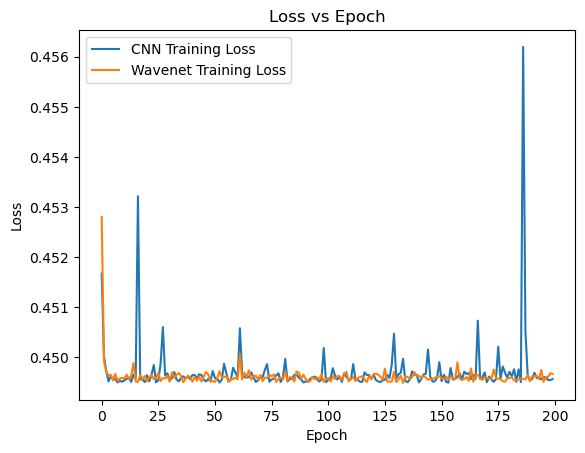

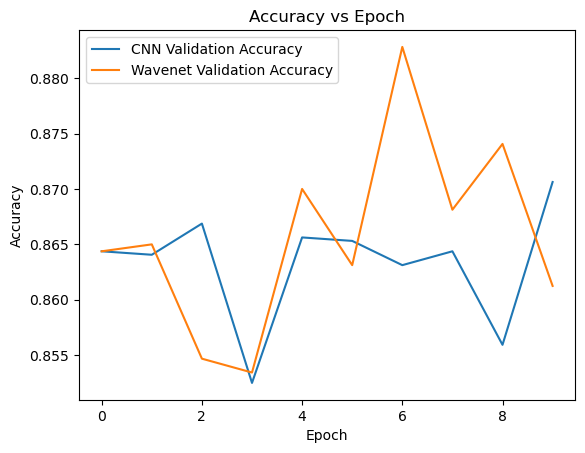

In [7]:
# Plot the loss and accuracy

plt.figure()
plt.plot(CNNtrain_loss, label="CNN Training Loss")
# plt.plot(CNNval_los, label="CNN Validation Loss")
plt.plot(Wavetrain_loss, label="Wavenet Training Loss")
# plt.plot(Waveval_los, label="Wavenet Validation Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.show()

plt.figure()
plt.plot(CNNval_accuracy, label="CNN Validation Accuracy")
plt.plot(Waveval_accuracy, label="Wavenet Validation Accuracy")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epoch")
plt.show()
